## 인물사진 모드 만들기🤳💁‍♀️

___

💬 아이폰의 인물사진 모드(Portrait mode)로 촬영하면 인물을 제외한 배경은 흐리게 처리하여 피사체가 더 도드라지게 보입니다. 이번 프로젝트는 **딥러닝을 이용하여 인물사진 모드를 구현해보는 것**입니다.

💬 배경을 흐리게 하는 효과를 **shallow depth of field** 또는 **shallow focus**라고 합니다. 원래는 전문적인 카메라에서 생기는 현상이지만 최신 핸드폰은 2개의 렌즈를 통해 사진에 shallow focus **처리**를 합니다. 

💬 2개의 카메라로 이미지를 받아들이면 핸드폰은 **두 이미지를 비교하여 어떤 물체가 가까이 있고, 멀리 있는지를 파악해냅니다.**(가까이 있는 물체는 두 이미지 간의 차(disparity)가 크고, 멀리 있는 물체는 disparity가 작음) 이렇게 알아낸 거리정보를 기반으로 멀리 있는 물체를 흐리게 하는 것이 인물사진 모드의 원리입니다.

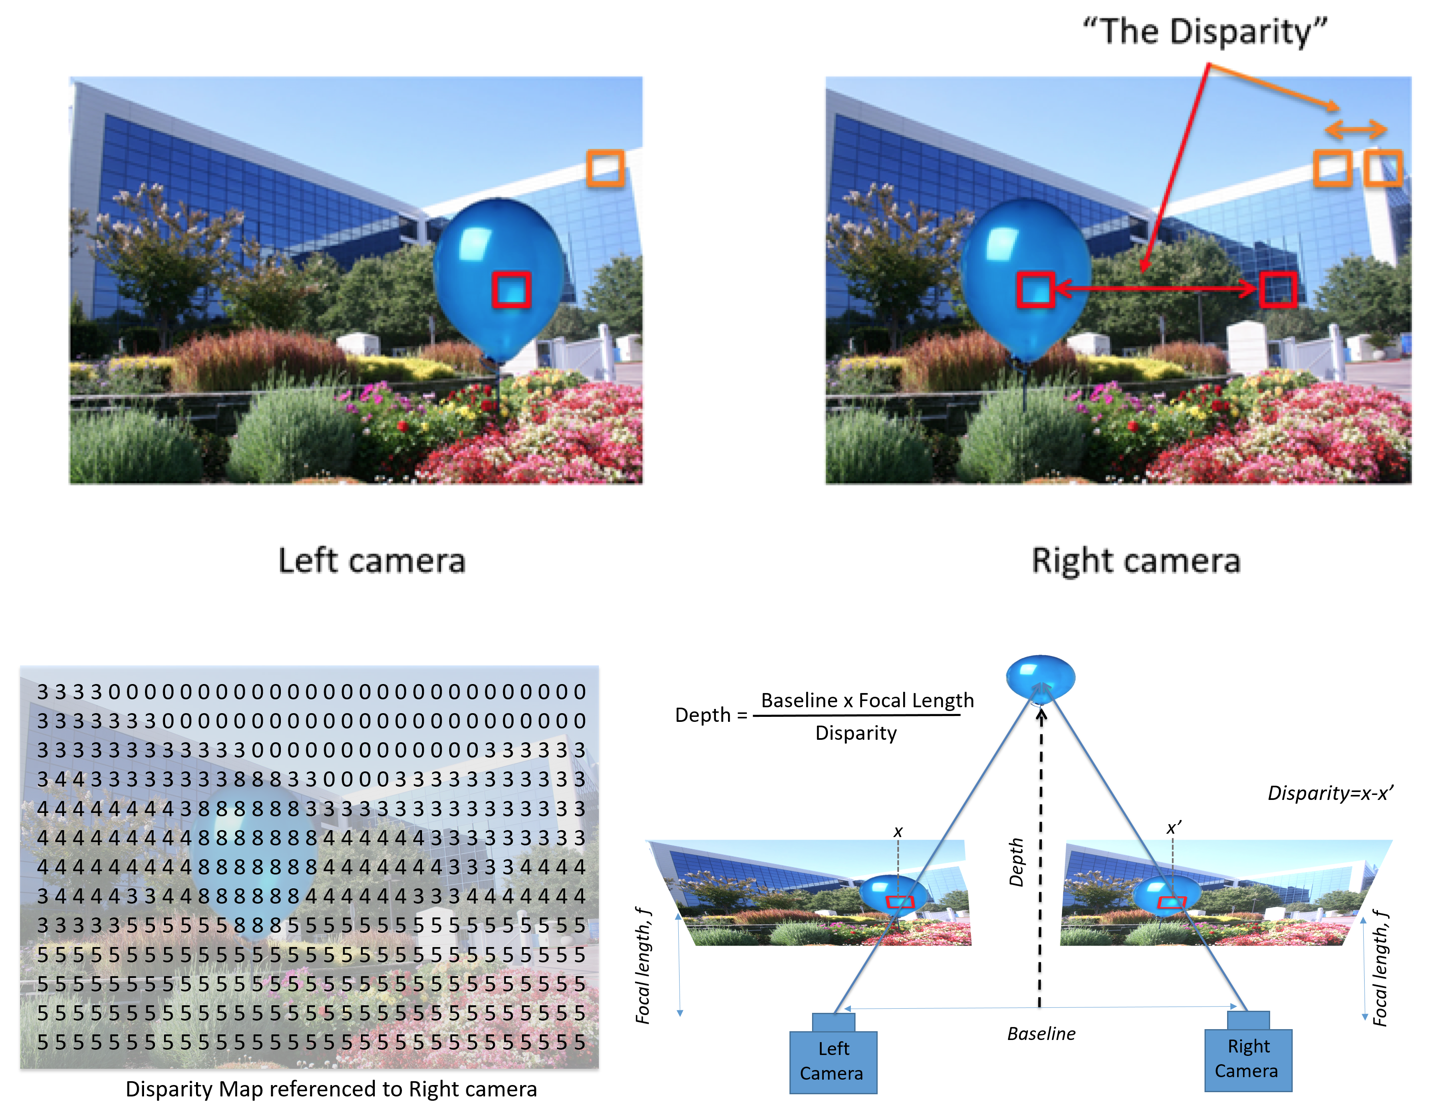

___

### 0. 어떻게 구현할까? 아웃라인 잡기


**이번 프로젝트에서는 하나의 렌즈로 촬영한 사진만으로 딥러닝을 이용하여 shallow focus 효과를 적용해볼 것입니다.**

과정은 다음과 같습니다.

📍 시맨틱 분할(Semantic segmentation)로 인물과 배경 분리하기

📍 배경 블러(blur)처리 하기

📍 두 이미지 합성하기

___

### 1. 사진 준비하기

In [1]:
import os
import urllib
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation

`urllib`: 웹에서 데이터를 다운로드 하는 패키지  
`cv2`: `OpenCV`로 이미지 처리하기 위한 라이브러리  
`pixellib`: 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리  


cf) 모듈, 패키지, 라이브러리의 차이 https://www.bjcoding.com/343

(960, 1280, 3)


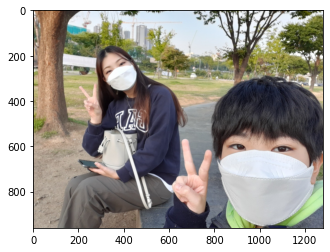

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

___

### 2. 세그멘테이션으로 사람 분리하기

#### 2.1. 세그멘테이션이란?

**`이미지 세그멘테이션(Image Segmentaion)`**: 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법. 모든 픽셀에 라벨을 할당하고 같은 라벨은 공통적인 특징을 가진다고 가정.

![](https://i.imgur.com/Sp5l9P9.png)

**`시맨틱 세그멘테이션(Semantic Segmentation`**: 사람의 인식처럼 물리적 의미 단위로 인식하는 세그멘테이션. 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 **classification**하는 것.

![](https://media5.datahacker.rs/2021/11/image-16.png)

**`인스턴스 세그멘테이션(Instance Segmentation)`**: 하나의 클래스 내에서도 각각의 개체를 다르게 인식하는 것. 예를 들면 하나의 사진에서 사람1, 사람2, 사람3 등으로 분리하는 것.

![](https://miro.medium.com/max/591/1*Ox16veM29OVxGgIPrVmMhQ.png)
![](https://miro.medium.com/max/875/1*jHv5C23SLtL3UFeR8VnohQ.png)

___

#### 2.2. `DeepLab` 모델 이용하여 시맨틱 세그멘테이션 해보기

세그멘테이션 모델에는 다양한 종류가 있습니다. (`DeepLab`, `FCN`, `SegNet`, `U-Net` 등) 그 중 성능이 좋은 `DeepLab v3+`을 사용할 것입니다. 다음은 `DeepLab`의 구조 특징에 관한 설명입니다.

* **`Atrous Convolution`**

> *a trous: (french) '구멍이 있는'*

일반적인 Convolution (2D convolution using a kernel size of 3, stride of 1 and padding) 👇

![](https://blog.kakaocdn.net/dn/L4OGj/btq25ZYvmXA/X3wI5PCqZ8yAgkoKnGcopk/img.gif)


atrous convolution (2D convolution using a 3 kernel with a dilation rate of 2 and no padding) 👇

![](https://blog.kakaocdn.net/dn/dXRWM7/btq250wkFQj/OKY0Jy2k7TNE7zPvtpivh0/img.gif)

일반적인 convolution과 달리 atrous convolution은 필터의 내부에 빈 공간을 둔 채로 작동합니다. 얼마나 빈 공간을 둘 지는 파라미터 r(rate)로 결정합니다. r=1인 경우 기존 convolution과 동일하고, r이 커질수록, 빈 공간이 넓어지게 됩니다. 

**필터에 빈 공간을 두면 동일한 조건일 때, 기존 convolution에 비해 더 넓은 field of view를 가질 수 있습니다.** 위의 그림을 보면, 기존 convolution의 경우 3x3 필터는 3x3의 시야(field of view)를 갖고 5x5 크기의 output을 출력합니다. 반면 아래 그림의 atrous convolution의 경우, 같은 3x3 필터로 5x5의 시야(field of view)를 갖고 3x3 크기의 output을 출력합니다.

보통 semantic segmentation에서 높은 성능을 내기 위해서는 한 픽셀이 커버하는 영역이 크면 클수록 좋습니다. 따라서 atrous convolution을 이용하면 파라미터 수를 늘리지 않고도 segmentation을 잘 수행할 수 있게됩니다.

___

* **`Depthwise separable convolution`**

일반적인 convolution 👇


![](https://bloglunit.files.wordpress.com/2018/07/conv.png)

Depthwise separable convolution 👇

![](https://bloglunit.files.wordpress.com/2018/07/depthwise_separable_conv.png?w=300&h=435)

Depthwise separable convolution은 일반적인 convolution에서 진행되는 연산을 여러 단계로 나누어서 따로따로 계산하는 방법입니다. 따라서 결과값은 같지만 과정은 조금 더 복잡해집니다.

그런데도 Depthwise separable convolution을 사용하는 이유는, 기존 모델과 유사한 성능을 보이면서도 사용되는 파라미터 수와 연산량을 획기적으로 줄일 수 있기 때문입니다.

___

`PixelLib`이 제공하는 모델을 불러옵니다.

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f3efc0b49d0>)

다운로드한 모델을 이용해 원하는 `semantic_segmentation()` 모델을 생성합니다. **(PASCAL VOC 데이터셋으로 학습된 모델 http://host.robots.ox.ac.uk/pascal/VOC/)**

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

모델에 이미지를 입력합니다.

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

PASCAL VOC 데이터셋의 라벨 종류는 아래와 같이 20개 입니다.(background 제외)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

이 중 사람(`person`) 라벨을 가진 영역만 검출해내야 합니다.

모델 출력값을 살펴봅니다.

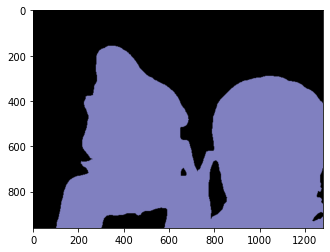

In [7]:
plt.imshow(output)
plt.show()

`output`에는 세그멘테이션 된 결과가 각각 다른 색상으로 담겨 있습니다.

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

`segvalues`에는 라벨 인덱스들이 담겨있는 `class_ids`와 `masks`가 들어있습니다. 지금 사진은 사람과 배경만 인식되기 때문에 `class_ids`에 0과 15만 들어있습니다.

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


`class_ids`를 통해 어떤 라벨들이 인식되었는지 확인해볼 수 있습니다.

___

물체마다 `output`에 어떤 색상으로 나타나 있는지 알아봅니다.

In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

사람의 색상은 인덱스값 15를 통해 알 수 있습니다. (다른 라벨은 `colormap[class_id]`로 찾을 수 있음)

In [11]:
colormap[15]

array([192, 128, 128])

`output` 이미지는 BGR 순서이고 `colormap`은 RGB 순서이므로 추출할 색상 값을 `output`에 맞춰 바꿔줍니다.

In [12]:
seg_color = (128, 128, 192)

`seg_color`로만 이루어진 마스크를 만들어 봅니다.

(960, 1280)


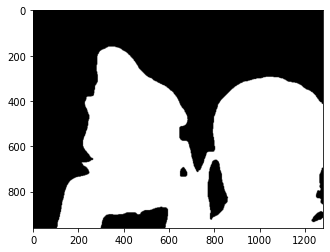

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원본과는 다르게 채널 정보가 없는 2 차원의 데이터가 되었습니다. 물체(사람)이 있는 위치는 1, 그 외는 0인 배열입니다.

원본 이미지와 겹쳐 세그멘테이션이 얼마나 잘 되었는지 확인해봅니다.

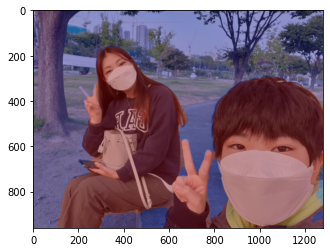

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

인물이 잘 분리되었네요! 제 경우에는 사람이 2명이 있고, 둘 다 마스크를 끼고 있음에도 잘 인식이 되고 있음을 알 수 있습니다.

___

### 3. 배경 흐리게 하기

`blur()`라는 함수가 있습니다. 이 함수를 이용해서 배경을 흐리게 만듭니다.

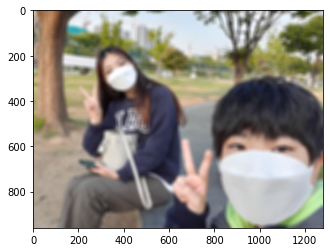

In [15]:
img_orig_blur = cv2.blur(img_orig, (20,20))  #blurring kernel size는 변경가능
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출합니다. 

* `cv2`의 bitwise 연산들 👇  
>`bitwise_not`: NOT 연산은 각 자릿수의 값을 반대로 바꾸는 연산  
>`bitwise_and`: AND 연산은 두 값의 각 자릿수를 비교해, 두 값 모두에 1이 있을 때에만 1을, 나머지 경우에는 0을 계산한다.  
>`bitwise_or`: OR 연산은 두 값의 각 자릿수를 비교해, 둘 중 하나라도 1이 있다면 1을, 아니면 0을 계산한다.  
>`bitwise_xor`: XOR 연산은 두 값의 각 자릿수를 비교해, 값이 같으면 0, 다르면 1을 계산한다.

원래 마스크에서는 배경이 0, 사람이 1이었는데, 반대로 만들어주기 위해서  `bitwise_not`를 이용해줍니다. 그 후 `bitwise_and` 연산을 이용하여 블러 이미지와 이미지 마스크의 두 값 모두 1인 배경 값만 추출하도록 합니다.

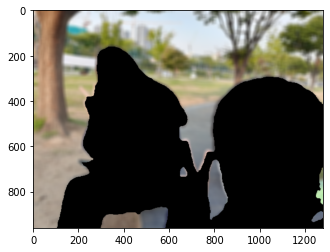

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

블러된 배경만 잘 추출되었습니다!

___ 

### 4. 흐린 배경과 원본 이미지 합성

세그멘테이션 마스크가 1인 부분만 원본 이미지를 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.

> `np.where(조건, 참일 때, 거짓일 때)`

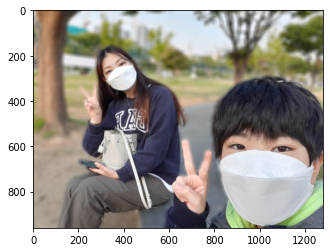

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 인물 모드 사진이 완성되었습니다 🥳🥳

___

## 더 나아가기 💡

### 1) 다른 피사체, 다른 배경

#### 1-1) 강아지를 포커싱하는 모델 만들기

(3624, 2718, 3)


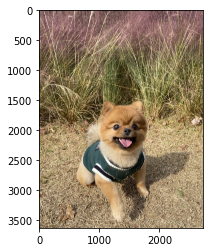

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_dog.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

강아지를 포커싱하는 모델 `dog_model`을 만들어 강아지 사진을 넣어줍니다.

In [19]:
dog_model = semantic_segmentation()
dog_model.load_pascalvoc_model(model_file)

In [20]:
dog_segvalues, dog_output = dog_model.segmentAsPascalvoc(img_path)

결과를 출력해봅니다.

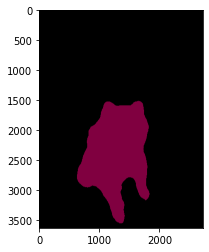

In [21]:
plt.imshow(dog_output)
plt.show()

In [22]:
for class_id in dog_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


`dog_segvalues`에는 `background`와 `dog` 라벨이 담겨있습니다.

In [23]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

`dog` 라벨의 인덱스는 12입니다.

In [24]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

강아지의 색상을 인덱스값(12)로 뽑아냅니다.

In [25]:
colormap[12]

array([ 64,   0, 128])

In [26]:
dog_seg_color = (128, 0, 64)

강아지 범위를 나타내는 마스크를 만들어봅니다.

(3624, 2718)


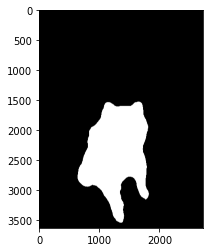

In [27]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(dog_output==dog_seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

마스크의 범위가 잘 지정되었는지 원래 이미지에 겹쳐서 확인해봅니다.

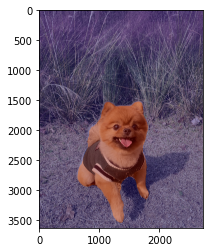

In [28]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

강아지를 잘 인식하고 있습니다.

이제 흐린 배경 이미지를 만들어줍니다.

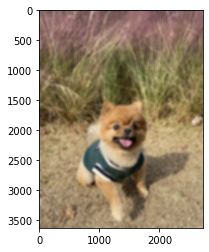

In [29]:
img_orig_blur = cv2.blur(img_orig, (50,50))  #blurring kernel size는 변경가능
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

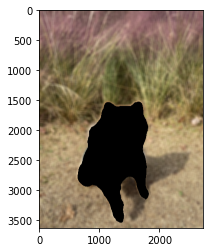

In [30]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

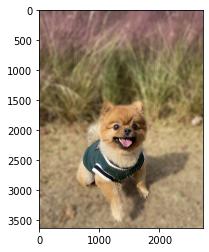

In [31]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

___

#### 1-2) 배경을 다른 이미지로 바꾸기

이번에는 강아지 사진의 배경을 바꾸어 항상 데려가고 싶었던 제주도에 데려가 보겠습니다..

In [32]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ocean.jpg'  
bg_img = cv2.imread(bg_path) 

print(bg_img.shape)
plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
plt.show()

(3024, 3024, 3)


이미지를 합성하기 위해 배경 이미지의 크기를 원본 이미지의 크기로 바꿔줍니다.

In [33]:
bg_img= cv2.resize(bg_img, dsize=(2718,3624))

print(bg_img.shape)
plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
plt.show()

(3624, 2718, 3)


In [34]:
new_bg_img = np.where(img_mask_color==255, img_orig, bg_img)
plt.imshow(cv2.cvtColor(new_bg_img, cv2.COLOR_BGR2RGB))
plt.show()

배경이미지가 잘 합성되었습니다.

___

### 2) 인물 모드 문제점 찾기

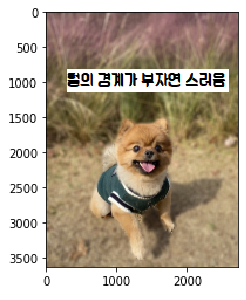

📍 **문제점 1**: 시맨틱 세그멘테이션의 정확도가 100%일 수 없기 때문에 영역 분리가 완벽하게 되지 않습니다. 첫번째 사진의 경우, 사람이 아닌 부분(옷)을 사람으로 인식하고 있습니다.

📍 **문제점 2**: 인물, 강아지 등 단순히 피사체 만을 인식하여 해당 피사체만 포커싱하는 형태로 구현되는 문제가 있습니다. 피사체와 같은 거리(깊이)에 위치하는 다른 대상들도 포커싱해야 자연스러운 심도표현이 가능합니다.

📍 **문제점 3**: 실제 카메라에서의 심도표현은 배경이 같은 정도로 흐리게 표현되는 것이 아니라, 거리에 따라 점점 더 흐리게 표현됩니다. 시맨틱 세그멘테이션을 이용한 심도표현은 이러한 구현이 불가합니다.

📍 **문제점 4**: 시맨틱 세그멘테이션의 정확도가 완벽하지 않기 때문에 특히 미세한 경계(예:강아지털)에서는 특히 정밀한 영역 분리가 되지 않습니다. 따라서 세그멘테이션이 어려운 피사체일수록 자연스러운 심도표현이 불가능합니다.

**이 모든 문제들은 시맨틱 세그멘테이션의 한계로 인해 발생합니다.** 따라서 정말 카메라와 같은 심도 표현을 가능하게 하려면 단순히 사진 속 대상들의 라벨을 파악하는 시맨틱 세그멘테이션을 넘어 사진 속의 거리를 아주 섬세하게 세그멘테이션하는 기술이 필요합니다.



___

### 3) 해결방안

#### 3-1) 3D 이미지센서

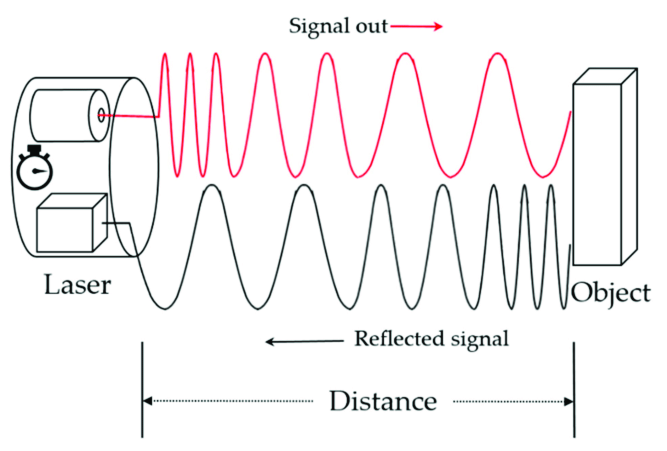



3D 이미지 센서 중 ToF 방식의 센서는 레이저를 사물에 조사한 후 반사된 신호를 계산하여 사물까지의 거리를 측정하는 기술입니다. ToF 이미지 센서들은 실제로 현재 많은 스마트폰에 적용되어 얼굴 인식 등에 사용된다고 합니다.

#### 3-2) 딥러닝을 이용한 거리측정 기술

기존의 거리측정 기술들은 양안영상을 기반으로 하여, 두 개의 카메라로 촬영한 후 차이값을 통해 대상과의 거리를 계산해내는 방식입니다. 반면 `Struct2Depth`, `MonoDepth2`와 같은 딥러닝 모델들은 하나의 카메라로 촬영한 영상에서도 거리를 측정할 수 있도록 설계되었습니다.


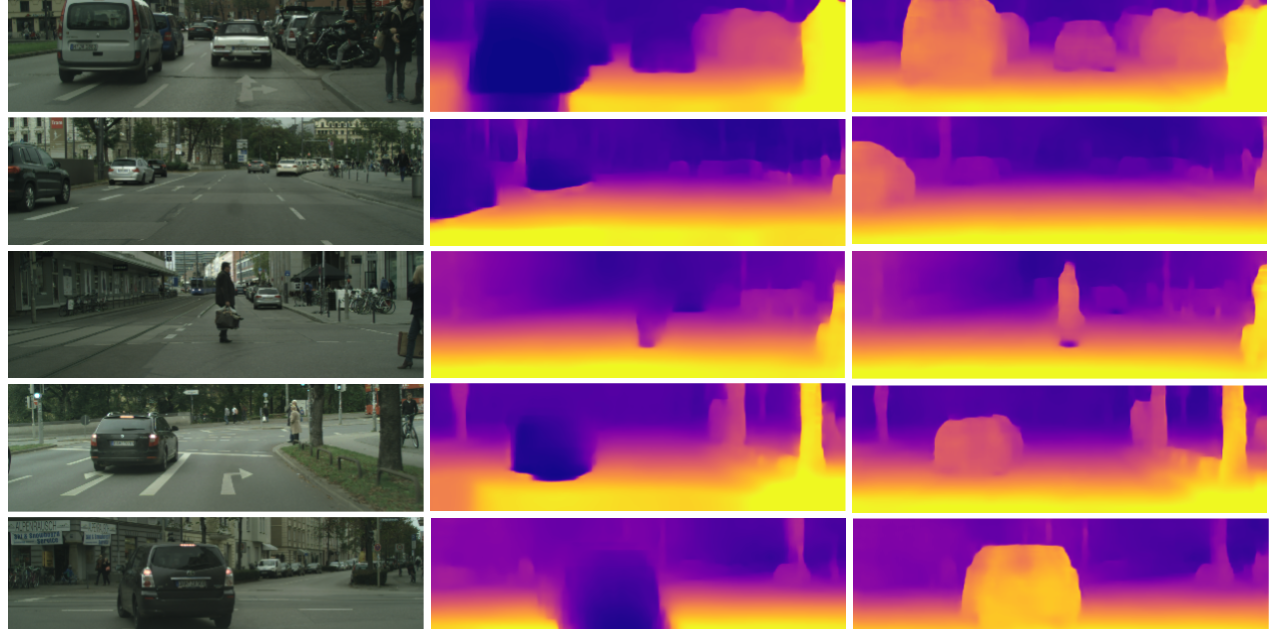


https://www.itfind.or.kr/publication/regular/weeklytrend/weekly/view.do?boardParam1=7869&boardParam2=7869





___


### `💡 n개의 마스크를 이용한 심도표현`

**위에 제시된 하드웨어 혹은 소프트웨어를 이용한 거리 정보를 앞에서 구현했던 semantic segmentation 모델에 적용한다면 보다 자연스러운 심도표현이 가능할 것입니다.**

📍 먼저, 앞의 모델에서는 mask를 하나만 생성했지만, 정밀한 심도표현을 위해서는 n개의 mask가 필요합니다. 

📍 포커스를 하고싶은 피사체 위치의 mask, 피사체보다 1/n만큼 멀거나 가까운 위치의 mask, 피사체보다 2/n만큼 멀거나 가까운 위치의 mask, ...

📍 semantic segmentation 모델에서 피사체를 분리해낸 다음, ToF로 알아냈거나, 딥러닝 거리측정 모델을 통해 파악한 거리 정보를 이용해서 피사체와 동일한 위치에 있는 사물들을 찾아냅니다. 그리고 이 사물들까지 포함하여 mask를 생성합니다. 그리고 피사체로부터의 거리를 계산하여 n개의 mask를 만들어냅니다.

📍 이후 n개의 mask마다 다른 정도의 blurring 효과를 적용하면 자연스러운 심도를 구현할 수 있습니다. (피사체와 가까운 것은 덜 흐리고 먼 것은 더 흐리게)

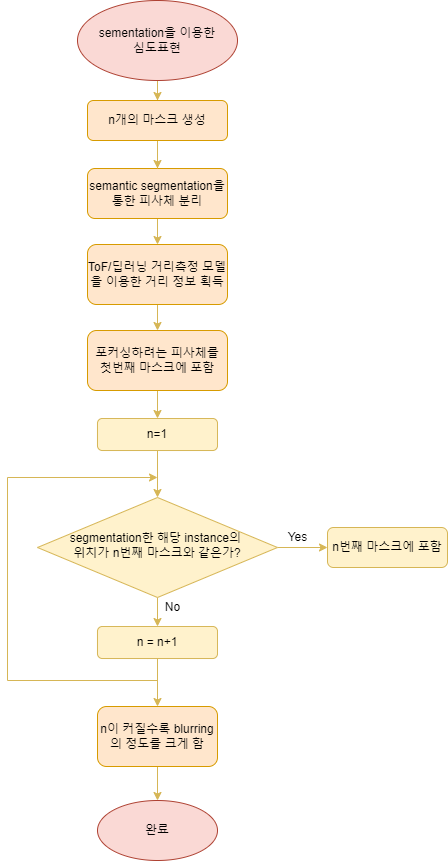
___

## 회고 🤔

1) '거리를 파악하는 것이 그렇게 어려운 기술일까?' 싶었는데 이번 노드를 통해 공부해보니 굉장히 어려운 분야라는 걸 느꼈다. Image Classification도 그렇고, Segmentation이나 Depth prediction 등 **우리의 시각으로는 쉽게 인식되는 것들을 알고리즘으로 구현해내는 건 정말 어려운 일인 것 같다.**

2) semantic segmentation을 통해 만든 모델의 문제점을 생각해볼 때, 평소에 쓰던 아이폰의 인물사진 모드와 비교하니 도움이 됐다. **'아이폰의 인물사진 모드처럼 구현하려면 어떻게 해야할까?' 혹은 '아이폰 인물사진 모드도 해결하지 못하는 문제는 무엇일까?'** 라고 질문하면서 문제점을 찾았다.

3) 3D 이미지센서나 온도를 감지하는 IR 센서, 혹은 딥러닝 거리측정 모델을 이용하면 성능의 개선이 있을 것 같은데 **거리측정을 위한 연산량이 엄청나게 늘어날 것 같다.** 비용적인 측면에서 성능개선이 이루어지지 못하는 것도 있을 것 같다.

4) 자율주행기능이 있는 차들이 도로를 다닌다닌 건... 이런 image segmentation과 depth prediction 기술이 굉장히 발전했다는 의미이지 않을까?! 딥러닝의 가능성은 정말 놀랍다. 자율주행 뿐만 아니라 의료분야나 환경분야(재활용 쓰레기 분류) 등에서도 CV의 활용성은 무궁무진할 것 같다. **앞으로의 발전이 기대되는 분야다!**